# Fraud Detection 


### This project features machine learning techniques to predict whether or not a transaction is fraud.  

### The main objective of the project is analyzing a large dataset and obtaining an appropriately fitted model using several approaches. 

##### Dataset used: E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016
##### Link: https://www.kaggle.com/ntnu-testimon/paysim1/data#fraud

##  1. Dataset exploration and transformation

The first thing is opening the dataset and exploring it to see its contents

In [3]:
import pandas as pd
df = pd.read_csv('financialfraud.csv', compression='zip')
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [2]:
#df.shape
#df.dtypes
#df.isna().sum()
#df.type.value_counts()
#df.nameOrig.nunique()
#df.nameDest.nunique()

In [3]:
df.isFraud.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

As it can be noticed, it is a very unbalanced dataset. Therefore, before balancing the data it is necessary to do some dataprep: Using a Label encoding method and evenly separating the dataset between train and test. 

There are three object type columns. The first one is type, which can be easily encoded using *get_dummies* since each category of transaction does not have a specific order and it has low cardinality(few categories). The other two object columns are nameOrig and nameDest. However, since there are over 6 million entries, We need to try to understand the actual fraudulent transactions. According to the description of the dataset: 

isFraud - Refers to the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers' accounts and try to empty the funds by transferring to another account and then cashing out of the system.

So, the fraudulent transactions are not made by the customers but by the agents. With this information, nameOrig and nameDest can be dropped from the dataset, and then .

In [4]:
df = df.drop(columns=['nameOrig','nameDest'], axis=1)
df.head(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0


In [5]:
dummy = pd.get_dummies(df['type'])
df = df.drop('type',axis= 1)
df = df.join(dummy)
df.head(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0


The next procedure is splitting the data to create new datasets for training and testing, making sure that the proportion of fraud and legitimate transactions are the same. And then, this is verified.

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop('isFraud', axis=1)
y = df.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [7]:
y_train.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

## 2. Dataset Balancing

In order to train a model with these characteristics, the first thing to do is balancing the dataset. Otherwise the model would end up biased and say that 100% of the transactions are not fraudulent, and that's not the point.  It is necessary to establish a decision boundary to precisely determine the response surface, because the observations that are far from that boundary do not bring much information to solve the problem.

In [8]:
from sklearn.utils import resample

train = pd.concat([X_train,y_train], axis=1)
legit = train[train.isFraud==0]
fraud = train[train.isFraud==1]

oversampled_fraud = resample(fraud, replace=True, n_samples=len(legit), random_state=0)
oversampled = pd.concat([legit, oversampled_fraud])
undersampled_fraud = resample(legit, replace=True, n_samples=len(fraud), random_state=0)
undersampled = pd.concat([fraud, undersampled_fraud])

print(oversampled.isFraud.value_counts(), undersampled.isFraud.value_counts())


1    5083526
0    5083526
Name: isFraud, dtype: int64 1    6570
0    6570
Name: isFraud, dtype: int64


## 3. Feature Selection

It is also necessary to think about **maximizing the score and minimizing the complexity of the problem**. This is done by selecting the features that have a bigger impact on the target. A good technique is using a correlation heatmap. 

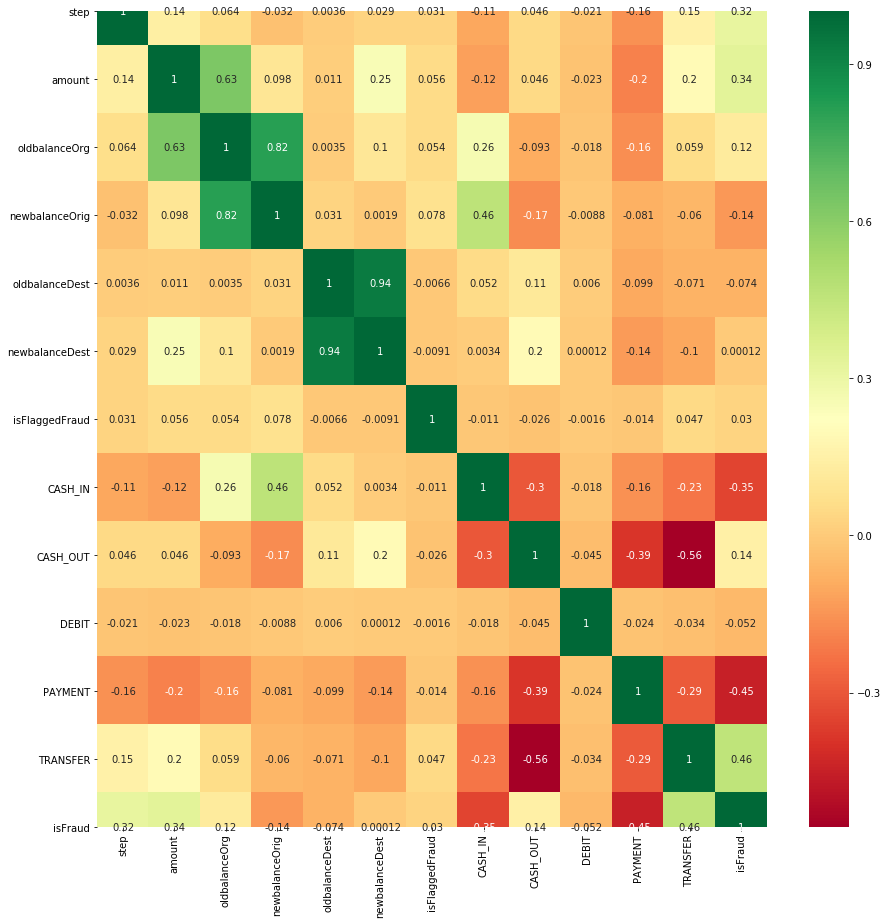

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
mat = undersampled.corr()
top_corr_features = mat.index
plt.figure(figsize=(15,15))
g=sns.heatmap(undersampled[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [10]:
mat>= 0

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
step,True,True,True,False,True,True,True,False,True,False,False,True,True
amount,True,True,True,True,True,True,True,False,True,False,False,True,True
oldbalanceOrg,True,True,True,True,True,True,True,True,False,False,False,True,True
newbalanceOrig,False,True,True,True,True,True,True,True,False,False,False,False,False
oldbalanceDest,True,True,True,True,True,True,False,True,True,True,False,False,False
newbalanceDest,True,True,True,True,True,True,False,True,True,True,False,False,True
isFlaggedFraud,True,True,True,True,False,False,True,False,False,False,False,True,True
CASH_IN,False,False,True,True,True,True,False,True,False,False,False,False,False
CASH_OUT,True,True,False,False,True,True,False,False,True,False,False,False,True
DEBIT,False,False,False,False,True,True,False,False,False,True,False,False,False


The heatmap shows that the features that have the most impact on the target is fraud are: step, amount, oldbalanceOrg, newbalanceDest, isflaggedfraud, cash_out and transfer. Therefore, these are the features that will be used for further modeling.

In [11]:
Xo = oversampled.drop(['isFraud', 'newbalanceOrig', 'oldbalanceDest','CASH_IN','DEBIT','PAYMENT'], axis=1)
yo = oversampled.isFraud
Xu = undersampled.drop(['isFraud', 'newbalanceOrig', 'oldbalanceDest','CASH_IN','DEBIT','PAYMENT'], axis=1)
yu = undersampled.isFraud

## 4. Baseline

### 4.1 Modeling and Testing a Logistic Regression (Using Undersampling) 

Finally, it is possible to train and test by using a simple logistic regression. However, in order to set an appropriate logistic regression model it is recommended to use regularization. "*Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. The larger λ is the less likely it is that the parameters will be increased in magnitude simply to adjust for small perturbations in the data. In your case however, rather than specifying λ, you specify C=1/λ.*"  

Reference: https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, learning_curve

logistic1 = LogisticRegression(C=100, n_jobs=-1) 
pipeline = Pipeline(steps=[('dataprep', StandardScaler()),
                           ('logistic', logistic1), 
                          ])

pipeline.fit(Xu, yu)

Pipeline(memory=None,
         steps=[('dataprep',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [86]:
cross_val_score(pipeline, Xu, yu, scoring='roc_auc', cv=KFold(n_splits=5, shuffle=True))

array([0.96877496, 0.96506422, 0.9720696 , 0.96575822, 0.9675649 ])

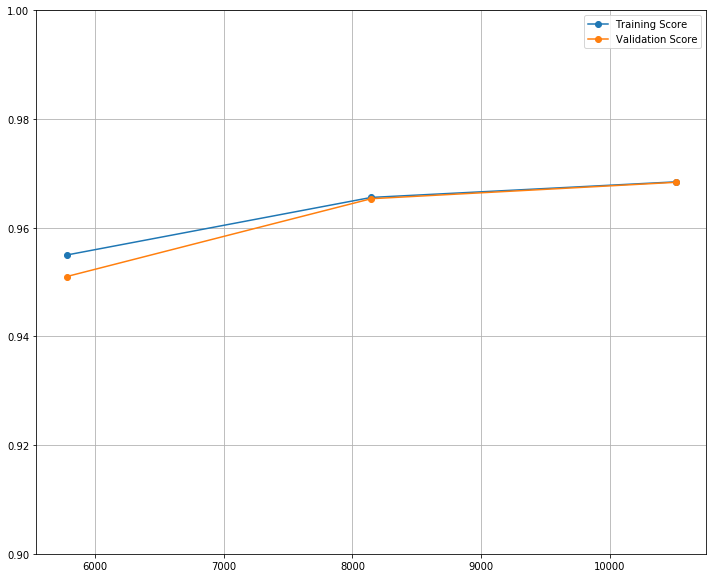

In [16]:
import matplotlib.pyplot as plt
curves = learning_curve(pipeline, Xu, yu, scoring='roc_auc', n_jobs=-1)

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.9, 1])
plt.legend()
plt.grid()

The learning curve shows that the model needs more data to learn since it did not stabilize, and it is very likely to overfit.  

Nevertheless, with this result, it is possible to test the data to see how the model fits.

In [18]:
from sklearn.metrics import roc_auc_score
X_test = X_test.drop(['newbalanceOrig', 'oldbalanceDest','CASH_IN','DEBIT','PAYMENT'], axis=1)
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.9681012778420718

Then, the next step is doing the confusion matrix to test precision and recall.

In [83]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
confusion_matrix(y_test, pipeline.predict(X_test))

array([[1007734,  263147],
       [    221,    1422]], dtype=int64)

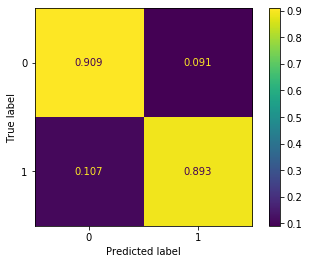

In [20]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='.3f', normalize='true')

These results show that the model was able to predict 87.6% of the cases where there was fraud. The downside was a hit rate of 21%, and a capture rate of 12.4%. This is not a good model. 

In [72]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
print('recall_score: ', recall_score(yu, logistic1.predict(Xu)))
print('precision_score: ', precision_score(yu, logistic1.predict(Xu)))
print('f1_score: ', f1_score(yu, logistic1.predict(Xu)))
print('accuracy_score: ', accuracy_score(yu, logistic1.predict(Xu)))


recall_score:  0.9891933028919331
precision_score:  0.6996447410916138
f1_score:  0.8195977047733148
accuracy_score:  0.7822678843226788


In [140]:
y_predicted = (logistic1.predict_proba(X_test)[:, 1] > 0.1)
confusion_matrix(y_test, y_predicted)

array([[721596, 549285],
       [    29,   1614]], dtype=int64)

In [141]:
print('recall_score: ', recall_score(y_test, logistic1.predict(X_test)))
print('precision_score: ', precision_score(y_test, logistic1.predict(X_test)))
print('f1_score: ', f1_score(y_test, logistic1.predict(X_test)))
print('accuracy_score: ', accuracy_score(y_test, logistic1.predict(X_test)))

recall_score:  0.9823493609251369
precision_score:  0.0029297619523033303
f1_score:  0.005842100405218798
accuracy_score:  0.5683279843837916


Another tool to understand the model is plotting a roc_curve.

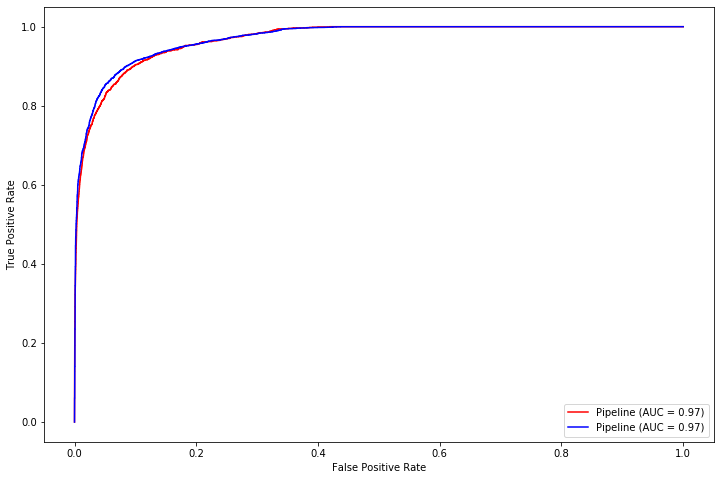

In [24]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(pipeline, X_test, y_test, color='red', ax= ax)
plot_roc_curve(pipeline, Xu, yu, color='blue', ax=ax)

### 4.2 Modeling and Testing a Logistic Regression (Using Oversampling)

In [82]:
logistic = LogisticRegression(C=10, n_jobs=-1) 
pipeline = Pipeline(steps=[('dataprep', StandardScaler()),
                           ('logistic', logistic), 
                          ])

pipeline.fit(Xo, yo)

Pipeline(memory=None,
         steps=[('dataprep',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [83]:
cross_val_score(pipeline, Xo, yo, scoring='roc_auc', cv=KFold(n_splits=5, shuffle=True))

array([0.98161789, 0.98175314, 0.98154225, 0.98160148, 0.98157908])

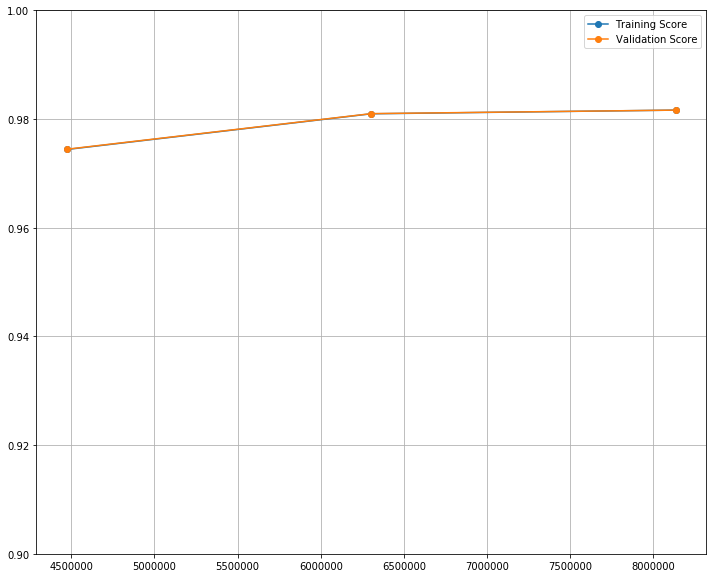

In [84]:
import matplotlib.pyplot as plt
curves = learning_curve(pipeline, Xo, yo, scoring='roc_auc', n_jobs=-1)

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.9, 1])
plt.legend()
plt.grid()

In [85]:
confusion_matrix(y_test, pipeline.predict(X_test))

array([[1190923,   79958],
       [    107,    1536]], dtype=int64)

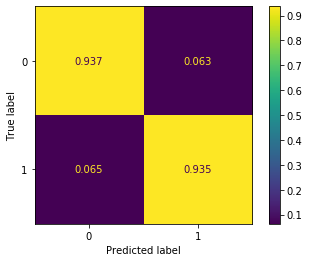

In [86]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='.3f', normalize='true')

In [87]:
print('recall_score: ', recall_score(yo, logistic.predict(Xo)))
print('precision_score: ', precision_score(yo, logistic.predict(Xo)))
print('f1_score: ', f1_score(yo, logistic.predict(Xo)))
print('accuracy_score: ', accuracy_score(yo, logistic.predict(Xo)))


recall_score:  0.9874040183919587
precision_score:  0.6964575182606121
f1_score:  0.8167951309546524
accuracy_score:  0.7785280334948617


In [88]:
print('recall_score: ', recall_score(y_test, logistic.predict(X_test)))
print('precision_score: ', precision_score(y_test, logistic.predict(X_test)))
print('f1_score: ', f1_score(y_test, logistic.predict(X_test)))
print('accuracy_score: ', accuracy_score(y_test, logistic.predict(X_test)))

recall_score:  0.9920876445526476
precision_score:  0.0029709448880609938
f1_score:  0.005924149085027894
accuracy_score:  0.5701220566370457


### The scores show a very similar tendency when using oversampling and undersampling. With this in mind, a good way to deal with further modeling is using undersampling, to be able to test several models with less observations.

## 5. Modeling and testing using other tools

In [1]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier

### 5.1 Decision Tree

Before going any further, it is recommended to determine the best depth setting for the Decision Tree.

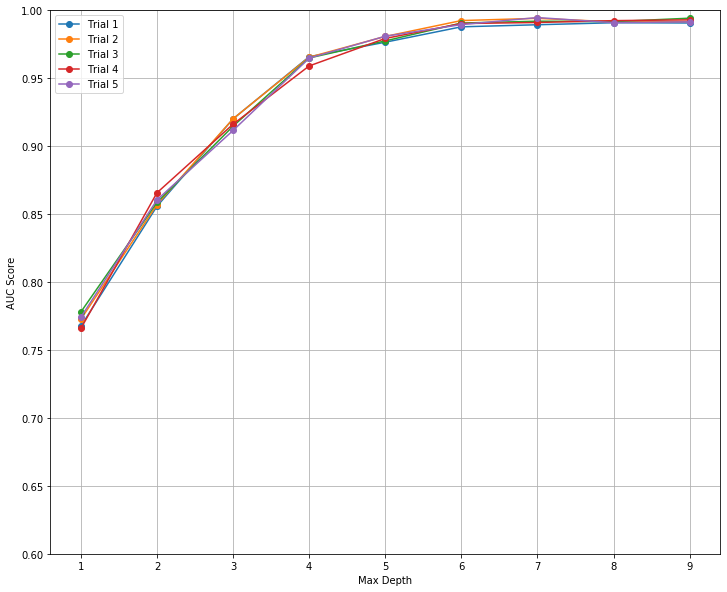

In [93]:
scores = []
for max_depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=max_depth)
    scores.append(cross_val_score(model, Xu, yu, scoring='roc_auc', cv=KFold(5, shuffle=True)))
    
fig, ax = plt.subplots(figsize=(12,10))    
plt.plot(range(1, 10), scores, '-o');
plt.ylim([0.6, 1])
plt.xlabel('Max Depth')
plt.ylabel('AUC Score')
plt.grid()
plt.legend([f'Trial {i+1}' for i in range(len(scores))])

According to the graph, a depth=6 will generalize well. After 6, the model stabilizes.

In [144]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(Xu, yu)
pd.DataFrame(zip(tree.feature_importances_, Xu.columns), columns=['importance','variable']).sort_values(by='importance')

,importance,variable
4,0.000000,isFlaggedFraud
6,0.036939,TRANSFER
5,0.051684,CASH_OUT
0,0.052053,step
3,0.063082,newbalanceDest
1,0.275704,amount
2,0.520539,oldbalanceOrg


According to the decision tree, the most important features are oldbalanceOrg, followed by amount and newbalanceDest. Step TRANSFER, and CASH_OUT  show some relevance too. Now, it is necessary to analize the score of the model when using a 6 branch deep decision tree.

In [95]:
results = cross_val_score(tree, Xu, yu, cv=KFold(5, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.9907864063647309, 0.002790105938365521)

In [99]:
confusion_matrix(y_test, tree.predict(X_test))

array([[1207849,   63032],
       [     86,    1557]], dtype=int64)

In [100]:
print('recall_score: ', recall_score(y_test, tree.predict(X_test)))
print('precision_score: ', precision_score(y_test, tree.predict(X_test)))
print('f1_score: ', f1_score(y_test, tree.predict(X_test)))
print('accuracy_score: ', accuracy_score(y_test, tree.predict(X_test)))

recall_score:  0.9476567255021302
precision_score:  0.02410627196581461
f1_score:  0.04701654789225752
accuracy_score:  0.9503993637841015


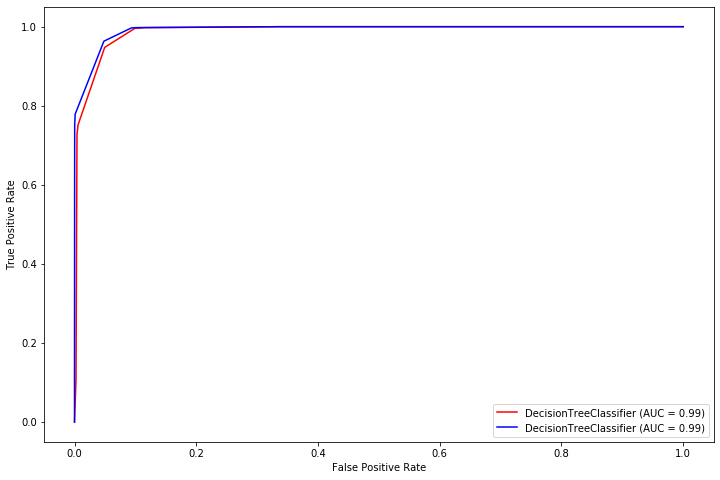

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(tree, X_test, y_test, color='red', ax= ax)
plot_roc_curve(tree, Xu, yu, color='blue', ax=ax)

Again, this model shows very good recall and accuracy, but, precision and F1 score are too low. It ended up overfitted.

### 5.2 Suport Vector Machine

Testing a Support Vector Machine:

In [51]:
svm = SVC(C=0.1, kernel='rbf', max_iter = 2000)
svm_pipeline = Pipeline(steps=[('dataprep', StandardScaler()),
                           ('svm', svm), 
                          ])
svm_pipeline.fit(Xu, yu)

C:\Users\Alvaro Camacho\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('dataprep',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=2000,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [52]:
results = cross_val_score(svm_pipeline, Xu, yu, cv=KFold(5, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

C:\Users\Alvaro Camacho\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Alvaro Camacho\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Alvaro Camacho\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Alvaro Camacho\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(0.9578397134912245, 0.005799248033998118)

In [53]:
print('recall_score: ', recall_score(y_test, svm_pipeline.predict(X_test)))
print('precision_score: ', precision_score(y_test, svm_pipeline.predict(X_test)))
print('f1_score: ', f1_score(y_test, svm_pipeline.predict(X_test)))
print('accuracy_score: ', accuracy_score(y_test, svm_pipeline.predict(X_test)))

recall_score:  0.8502738892270237
precision_score:  0.014892278827806027
f1_score:  0.029271870089051858
accuracy_score:  0.9271872279029708


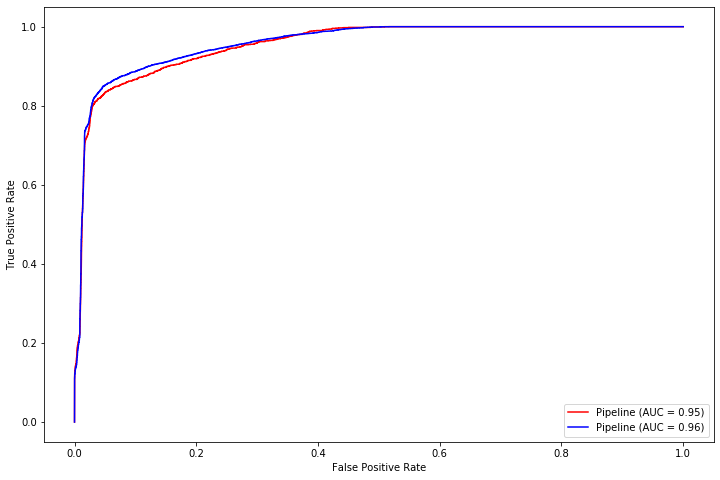

In [92]:
fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(svm_pipeline, X_test, y_test, color='red', ax= ax)
plot_roc_curve(svm_pipeline, Xu, yu, color='blue', ax=ax)

### 5.3 Bagging

In [94]:
bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(max_depth=6),
                            n_estimators= 100, oob_score= True)

results = cross_val_score(bagging, Xu, yu, cv=KFold(5, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.9946632152298438, 0.0008512761760743116)

In [95]:
bagging.fit(Xu, yu)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=6,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
   

In [96]:
confusion_matrix(y_test, bagging.predict(X_test))

array([[1195526,   75355],
       [     12,    1631]], dtype=int64)

In [97]:
print('recall_score: ', recall_score(y_test, bagging.predict(X_test)))
print('precision_score: ', precision_score(y_test, bagging.predict(X_test)))
print('f1_score: ', f1_score(y_test, bagging.predict(X_test)))
print('accuracy_score: ', accuracy_score(y_test, bagging.predict(X_test)))

recall_score:  0.992696287279367
precision_score:  0.021185670121840333
f1_score:  0.041485965737832094
accuracy_score:  0.9407736121283371


In [131]:
y_predicted = (bagging.predict_proba(X_test)[:, 1] > 0.98)
confusion_matrix(y_test, y_predicted)

array([[1269406,    1475],
       [    464,    1179]], dtype=int64)

In [132]:
print('recall_score: ', recall_score(y_test, y_predicted))
print('precision_score: ', precision_score(y_test, y_predicted))
print('f1_score: ', f1_score(y_test, y_predicted))
print('accuracy_score: ', accuracy_score(y_test, y_predicted))

recall_score:  0.7175897748021911
precision_score:  0.4442351168048229
f1_score:  0.5487549453106819
accuracy_score:  0.998476256636417


### 5.4 Stacking

In [142]:
from mlxtend.classifier import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(Xu, yu)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [149]:
stacking = StackingClassifier(classifiers=[tree, bagging, pipeline], 
                              meta_classifier=logistic1, 
                              use_probas=True, 
                              average_probas=True)

In [150]:
stacking.fit(Xu,yu)

StackingClassifier(average_probas=True,
                   classifiers=[DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=6,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                  

In [151]:
confusion_matrix(y_test, stacking.predict(X_test))

array([[1212287,   58594],
       [     86,    1557]], dtype=int64)

In [152]:
print('recall_score: ', recall_score(y_test, stacking.predict(X_test)))
print('precision_score: ', precision_score(y_test, stacking.predict(X_test)))
print('f1_score: ', f1_score(y_test, stacking.predict(X_test)))
print('accuracy_score: ', accuracy_score(y_test, stacking.predict(X_test)))

recall_score:  0.9476567255021302
precision_score:  0.025884856444614388
f1_score:  0.05039324206233615
accuracy_score:  0.9538869207967787


In [164]:
y_predicted = (stacking.predict_proba(X_test)[:, 1] > 0.98)
confusion_matrix(y_test, y_predicted)

array([[1269688,    1193],
       [    450,    1193]], dtype=int64)

In [165]:
print('recall_score: ', recall_score(y_test, y_predicted))
print('precision_score: ', precision_score(y_test, y_predicted))
print('f1_score: ', f1_score(y_test, y_predicted))
print('accuracy_score: ', accuracy_score(y_test, y_predicted))

recall_score:  0.7261107729762629
precision_score:  0.5
f1_score:  0.5922065028543063
accuracy_score:  0.9987088652159016


### 5.5 Adaboost

In [166]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=6),
            n_estimators=50,
            learning_rate=.05)

results = cross_val_score(adaboost, Xu, yu, cv=KFold(5, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.998554034865801, 0.00027259326922433636)

In [168]:
adaboost.fit(Xu,yu)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=6,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [169]:
confusion_matrix(y_test, adaboost.predict(X_test))

array([[1254113,   16768],
       [     13,    1630]], dtype=int64)

In [185]:
y_predicted = (adaboost.predict_proba(X_test)[:, 1] > 0.99)
confusion_matrix(y_test, y_predicted)

array([[1270189,     692],
       [    405,    1238]], dtype=int64)

In [186]:
print('recall_score: ', recall_score(y_test, y_predicted))
print('precision_score: ', precision_score(y_test, y_predicted))
print('f1_score: ', f1_score(y_test, y_predicted))
print('accuracy_score: ', accuracy_score(y_test, y_predicted))

recall_score:  0.7534996956786366
precision_score:  0.6414507772020726
f1_score:  0.6929750909599776
accuracy_score:  0.9991379337442752


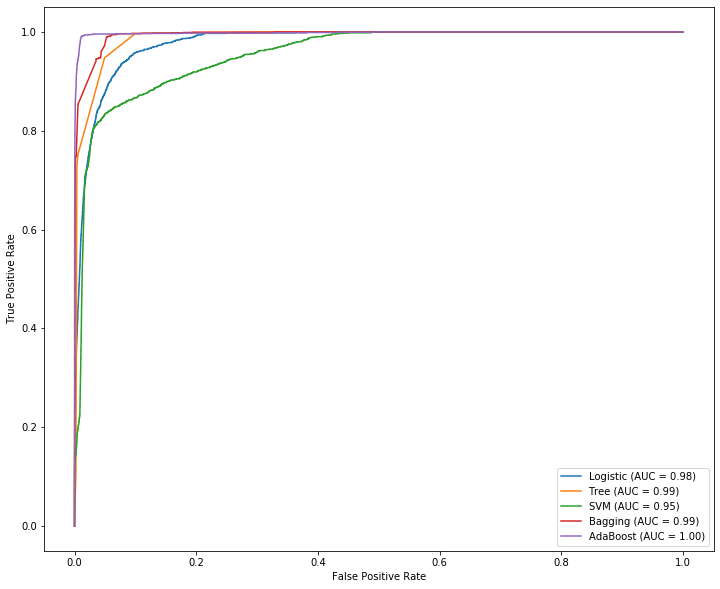

In [189]:
fig, ax = plt.subplots(figsize = (12,10))
plot_roc_curve(pipeline, X_test, y_test, name='Logistic', ax=ax)
plot_roc_curve(tree, X_test, y_test, name='Tree', ax=ax)
plot_roc_curve(svm_pipeline, X_test, y_test, name='SVM', ax=ax)
plot_roc_curve(bagging, X_test, y_test, name='Bagging', ax=ax)
plot_roc_curve(adaboost, X_test, y_test, name='AdaBoost', ax=ax)

### Finally, the ROC score after comparing all those models shows that the Adaboost model is by far the best fit for the dataset. In addition to that, a Logistic Regression provides a good perspective for a Baseline.